# Fake news detection using ML 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [2]:
fake = pd.read_csv("data/Fake.csv")
true = pd.read_csv("data/True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [5]:
import os
df = pd.read_excel(
     os.path.join("data/set_antrenare.xlsx"),
     engine='openpyxl',
)

In [6]:
#Modificam setul de date pentru cel de jos schimband subcategory in subject
df = df.rename(columns = {'subcategory': 'subject'}, inplace = False)
df["subject"].replace({"false news": "Covid19", "partially false": "Covid19", "true": "Covid19"}, inplace=True)
df["label"].replace({0: "fake", 1: "true"}, inplace=True)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,title,text,subject,label
0,FACEBOOK DELETES MICHIGAN ANTI-LOCKDOWN GROUP ...,Facebook has shuttered a popular group for Mic...,Covid19,fake
1,Other Viewpoints: COVID-19 is worse than the flu,We can now officially put to rest all comparis...,Covid19,true
2,Bermuda's COVID-19 cases surpass 100,The Ministry of Health in Bermuda has confirme...,Covid19,true
3,Purdue University says students face 'close to...,"Purdue University President Mitch Daniels, the...",Covid19,fake
4,THE HIGH COST OF LOCKING DOWN AMERICA: “WE’VE ...,Locking down much of the country may have help...,Covid19,fake


In [7]:
# Add flag to track fake and real
fake['label'] = 'fake'
true['label'] = 'true'

In [8]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [9]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,fake


In [10]:
data = pd.concat([data, df]).reset_index(drop = True)
data.shape

(48017, 4)

In [11]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [12]:
data.head()

,title,text,subject,label
0,Ex-Democratic leader who mulled dropping Clint...,WASHINGTON (Reuters) - The former head of the ...,politicsNews,true
1,BIG HYPOCRITE GLORIA STEINEM: Women Support Be...,Gloria Steinem does pretty much everything she...,politics,fake
2,3 MILLION ILLEGAL ALIENS Under Investigation F...,Part of the problem is that organizations are ...,politics,fake
3,Pay Off: The Establishment Rewards Comey with ...,21st Century Wire says For his role in helping...,US_News,fake
4,Trump Accidentally Applauds Obama’s Protectio...,Republican front runner Donald Trump loves to ...,News,fake


In [13]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,label
0,WASHINGTON (Reuters) - The former head of the ...,politicsNews,true
1,Gloria Steinem does pretty much everything she...,politics,fake
2,Part of the problem is that organizations are ...,politics,fake
3,21st Century Wire says For his role in helping...,US_News,fake
4,Republican front runner Donald Trump loves to ...,News,fake


In [14]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,label
0,washington (reuters) - the former head of the ...,politicsNews,true
1,gloria steinem does pretty much everything she...,politics,fake
2,part of the problem is that organizations are ...,politics,fake
3,21st century wire says for his role in helping...,US_News,fake
4,republican front runner donald trump loves to ...,News,fake


In [15]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [16]:
# Check
data.head()

,text,subject,label
0,washington reuters the former head of the us ...,politicsNews,true
1,gloria steinem does pretty much everything she...,politics,fake
2,part of the problem is that organizations are ...,politics,fake
3,21st century wire says for his role in helping...,US_News,fake
4,republican front runner donald trump loves to ...,News,fake


In [17]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mihai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
data.head()

,text,subject,label
0,washington reuters former head us democratic n...,politicsNews,true
1,gloria steinem pretty much everything prove bi...,politics,fake
2,part problem organizations registering people ...,politics,fake
3,21st century wire says role helping sow chaos ...,US_News,fake
4,republican front runner donald trump loves tel...,News,fake


## Basic data exploration

subject
Covid19             3119
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


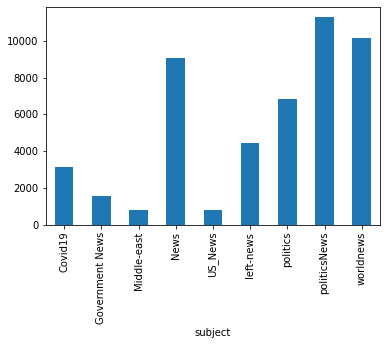

In [19]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

label
fake    24539
true    23478
Name: text, dtype: int64


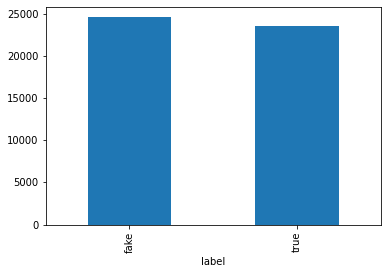

In [20]:
# How many fake and real articles?
print(data.groupby(['label'])['text'].count())
data.groupby(['label'])['text'].count().plot(kind="bar")
plt.show()

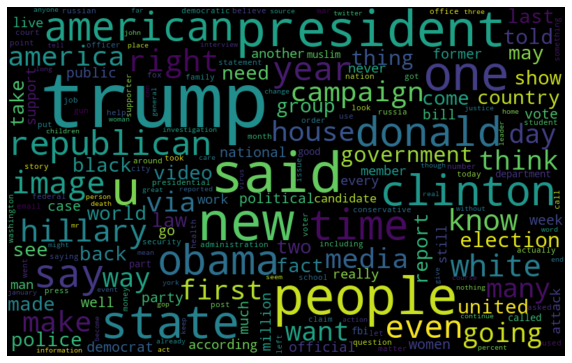

In [21]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["label"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

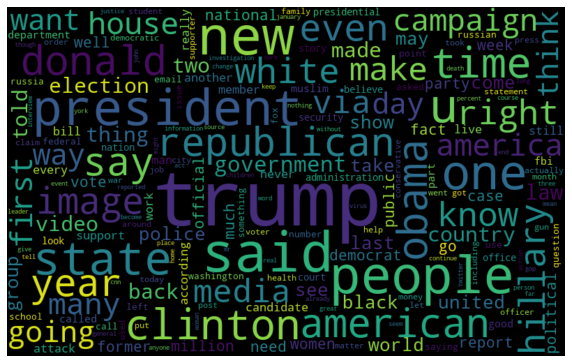

In [22]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["label"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [23]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

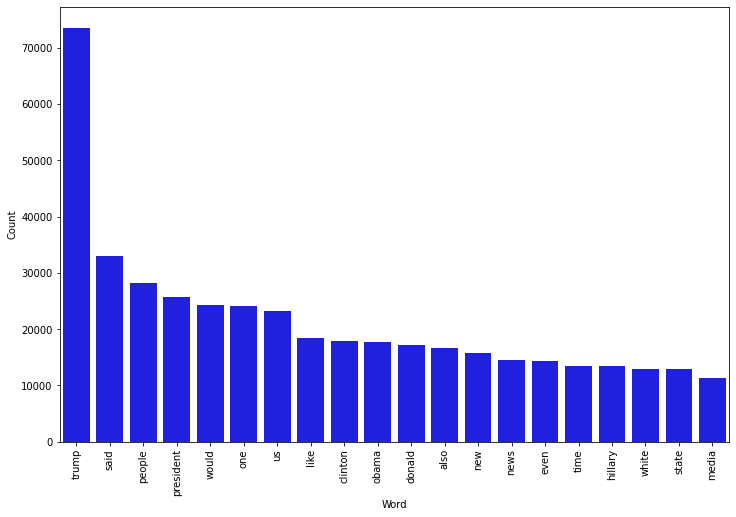

In [24]:
# Most frequent words in fake news
counter(data[data["label"] == "fake"], "text", 20)

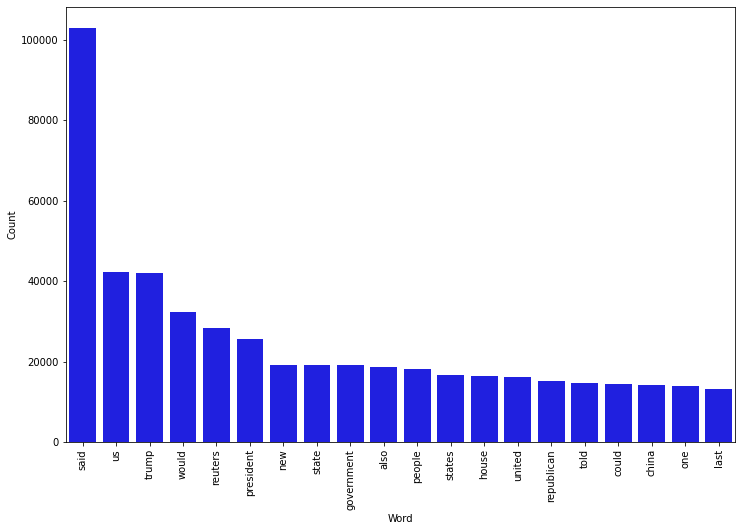

In [25]:
# Most frequent words in real news
counter(data[data["label"] == "true"], "text", 20)

## Modeling

In [26]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [27]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.label, test_size=0.2, random_state=42)

# **Naive Bayes**




In [28]:
dct = dict()
dct_p = dict()
dct_r = dict()
dct_f1 = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("precission: {}%".format(round(precision_score(y_test, prediction, pos_label='true')*100,2)))
print("recall: {}%".format(round(recall_score(y_test, prediction, pos_label='true')*100,2)))
print("F1 score: {}%".format(round(f1_score(y_test, prediction, pos_label='true')*100,2)))
print(classification_report(y_test, prediction))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)
dct_p['Naive Bayes'] = round(precision_score(y_test, prediction, pos_label='true')*100,2)
dct_r['Naive Bayes'] = round(recall_score(y_test, prediction, pos_label='true')*100,2)
dct_f1['Naive Bayes'] = round(f1_score(y_test, prediction, pos_label='true')*100,2)

accuracy: 93.38%
precission: 90.28%
recall: 96.68%
F1 score: 93.37%
              precision    recall  f1-score   support

        fake       0.97      0.90      0.93      4971
        true       0.90      0.97      0.93      4633

    accuracy                           0.93      9604
   macro avg       0.93      0.93      0.93      9604
weighted avg       0.94      0.93      0.93      9604



Confusion matrix, without normalization


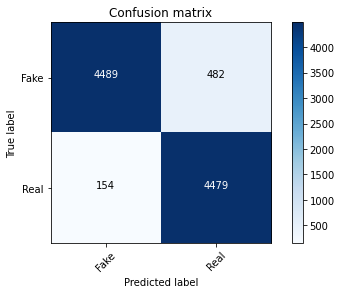

In [29]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Logistic regression**

In [30]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("precission: {}%".format(round(precision_score(y_test, prediction, pos_label='true')*100,2)))
print("recall: {}%".format(round(recall_score(y_test, prediction, pos_label='true')*100,2)))
print("F1 score: {}%".format(round(f1_score(y_test, prediction, pos_label='true')*100,2)))
print(classification_report(y_test, prediction))

dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)
dct_p['Logistic Regression'] = round(precision_score(y_test, prediction, pos_label='true')*100,2)
dct_r['Logistic Regression'] = round(recall_score(y_test, prediction, pos_label='true')*100,2)
dct_f1['Logistic Regression'] = round(f1_score(y_test, prediction, pos_label='true')*100,2)

accuracy: 97.65%
precission: 96.91%
recall: 98.25%
F1 score: 97.58%
              precision    recall  f1-score   support

        fake       0.98      0.97      0.98      4971
        true       0.97      0.98      0.98      4633

    accuracy                           0.98      9604
   macro avg       0.98      0.98      0.98      9604
weighted avg       0.98      0.98      0.98      9604



Confusion matrix, without normalization


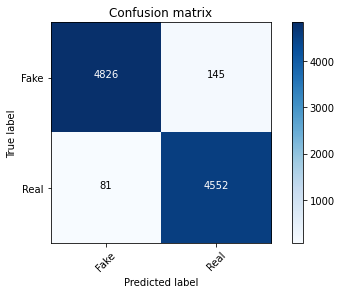

In [31]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Decision Tree**

In [32]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("precission: {}%".format(round(precision_score(y_test, prediction, pos_label='true')*100,2)))
print("recall: {}%".format(round(recall_score(y_test, prediction, pos_label='true')*100,2)))
print("F1 score: {}%".format(round(f1_score(y_test, prediction, pos_label='true')*100,2)))
print(classification_report(y_test, prediction))

dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)
dct_p['Decision Tree'] = round(precision_score(y_test, prediction, pos_label='true')*100,2)
dct_r['Decision Tree'] = round(recall_score(y_test, prediction, pos_label='true')*100,2)
dct_f1['Decision Tree'] = round(f1_score(y_test, prediction, pos_label='true')*100,2)

accuracy: 97.74%
precission: 97.46%
recall: 97.86%
F1 score: 97.66%
              precision    recall  f1-score   support

        fake       0.98      0.98      0.98      4971
        true       0.97      0.98      0.98      4633

    accuracy                           0.98      9604
   macro avg       0.98      0.98      0.98      9604
weighted avg       0.98      0.98      0.98      9604



Confusion matrix, without normalization


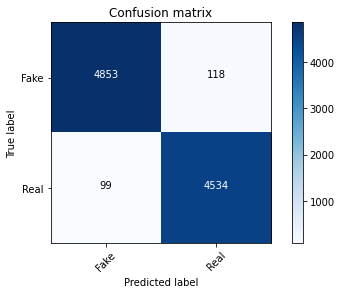

In [33]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Random Forest**

In [34]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("precission: {}%".format(round(precision_score(y_test, prediction, pos_label='true')*100,2)))
print("recall: {}%".format(round(recall_score(y_test, prediction, pos_label='true')*100,2)))
print("F1 score: {}%".format(round(f1_score(y_test, prediction, pos_label='true')*100,2)))
print(classification_report(y_test, prediction))

dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)
dct_p['Random Forest'] = round(precision_score(y_test, prediction, pos_label='true')*100,2)
dct_r['Random Forest'] = round(recall_score(y_test, prediction, pos_label='true')*100,2)
dct_f1['Random Forest'] = round(f1_score(y_test, prediction, pos_label='true')*100,2)

accuracy: 97.49%
precission: 96.47%
recall: 98.4%
F1 score: 97.42%
              precision    recall  f1-score   support

        fake       0.98      0.97      0.98      4971
        true       0.96      0.98      0.97      4633

    accuracy                           0.97      9604
   macro avg       0.97      0.98      0.97      9604
weighted avg       0.98      0.97      0.97      9604



Confusion matrix, without normalization


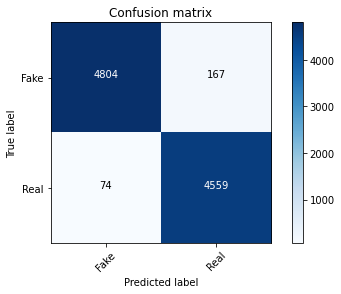

In [35]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## **SVM**

In [36]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("precission: {}%".format(round(precision_score(y_test, prediction, pos_label='true')*100,2)))
print("recall: {}%".format(round(recall_score(y_test, prediction, pos_label='true')*100,2)))
print("F1 score: {}%".format(round(f1_score(y_test, prediction, pos_label='true')*100,2)))
print(classification_report(y_test, prediction))

dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)
dct_p['SVM'] = round(precision_score(y_test, prediction, pos_label='true')*100,2)
dct_r['SVM'] = round(recall_score(y_test, prediction, pos_label='true')*100,2)
dct_f1['SVM'] = round(f1_score(y_test, prediction, pos_label='true')*100,2)

accuracy: 98.25%
precission: 97.53%
recall: 98.88%
F1 score: 98.2%
              precision    recall  f1-score   support

        fake       0.99      0.98      0.98      4971
        true       0.98      0.99      0.98      4633

    accuracy                           0.98      9604
   macro avg       0.98      0.98      0.98      9604
weighted avg       0.98      0.98      0.98      9604



Confusion matrix, without normalization


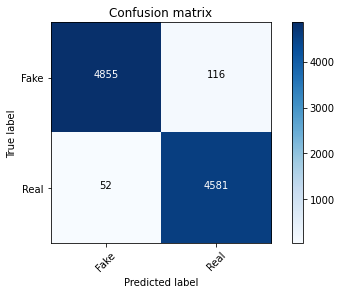

In [37]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## **KNN**

In [38]:
from sklearn.neighbors import KNeighborsClassifier
## **KNN**
#Create a svm Classifier
knn = KNeighborsClassifier(n_neighbors = 3)

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', knn)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("precission: {}%".format(round(precision_score(y_test, prediction, pos_label='true')*100,2)))
print("recall: {}%".format(round(recall_score(y_test, prediction, pos_label='true')*100,2)))
print("F1 score: {}%".format(round(f1_score(y_test, prediction, pos_label='true')*100,2)))
print(classification_report(y_test, prediction))

dct['KNN'] = round(accuracy_score(y_test, prediction)*100,2)
dct_p['KNN'] = round(precision_score(y_test, prediction, pos_label='true')*100,2)
dct_r['KNN'] = round(recall_score(y_test, prediction, pos_label='true')*100,2)
dct_f1['KNN'] = round(f1_score(y_test, prediction, pos_label='true')*100,2)

accuracy: 66.31%
precission: 95.15%
recall: 31.77%
F1 score: 47.64%
              precision    recall  f1-score   support

        fake       0.61      0.98      0.75      4971
        true       0.95      0.32      0.48      4633

    accuracy                           0.66      9604
   macro avg       0.78      0.65      0.61      9604
weighted avg       0.77      0.66      0.62      9604



Confusion matrix, without normalization


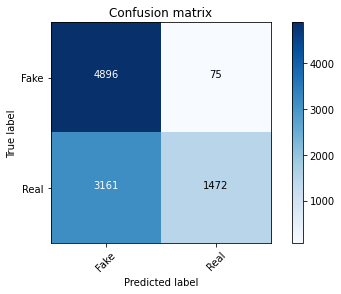

In [39]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Comparing** **Different Models**

([<matplotlib.axis.YTick at 0x2196dca8580>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

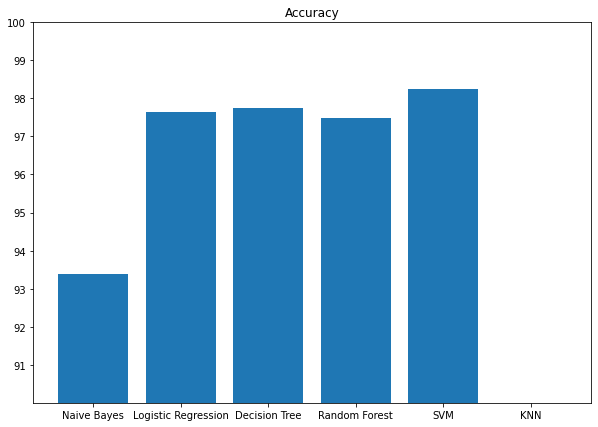

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.title('Accuracy')
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))

([<matplotlib.axis.YTick at 0x2196cb1e610>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

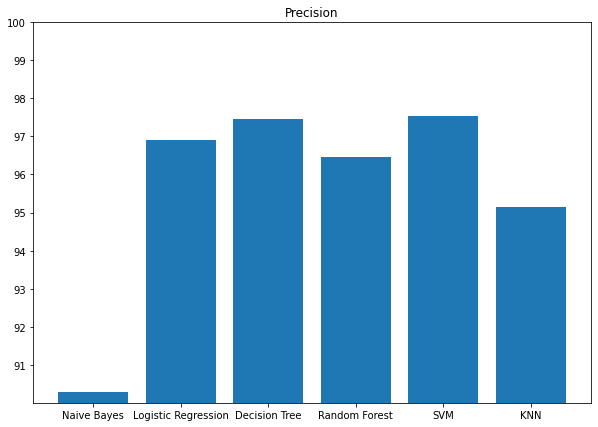

In [41]:
plt.figure(figsize=(10,7))
plt.bar(list(dct_p.keys()),list(dct_p.values()))
plt.title('Precision')
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))

([<matplotlib.axis.YTick at 0x21900619730>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

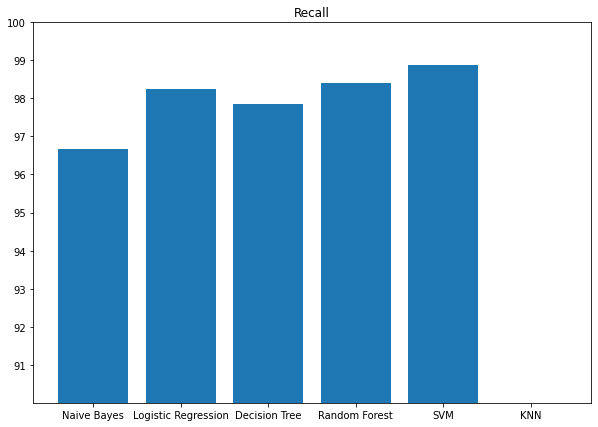

In [42]:
plt.figure(figsize=(10,7))
plt.bar(list(dct_r.keys()),list(dct_r.values()))
plt.title('Recall')
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))

([<matplotlib.axis.YTick at 0x219006878b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

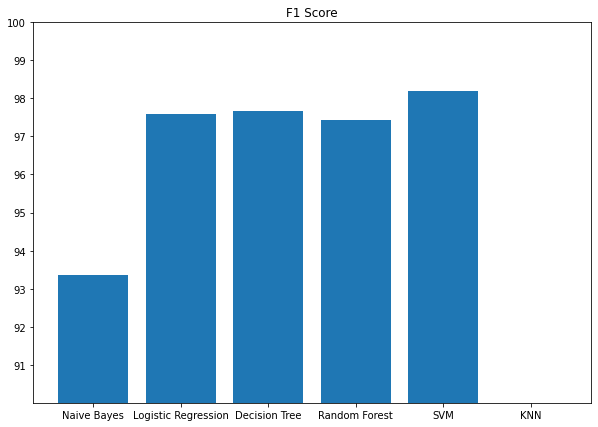

In [43]:
plt.figure(figsize=(10,7))
plt.bar(list(dct_f1.keys()),list(dct_f1.values()))
plt.title('F1 Score')
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))